In [19]:
!pip install yfinance ta

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import load_model
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf
import math

In [21]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Colab Notebooks/COMP5513'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).

Changed CWD to "/gdrive/My Drive/Colab Notebooks/COMP5513"


In [22]:
model = load_model('lstm-cnn.h5')

In [23]:
symbol = '2800.HK'#'AAPL'#'2800.HK'
stock = yf.Ticker(symbol)
df = stock.history(period="max")
stock_data = df[['Open',  'High',  'Low',  'Close', 'Volume']]

In [24]:
indicator_bollinger = BollingerBands(close=stock_data["Close"], window=20, window_dev=2)
macd = MACD(close=stock_data["Close"])
rsi = RSIIndicator(close=stock_data["Close"])
ichi = IchimokuIndicator(high=stock_data["High"],low=stock_data["Low"])

#get the technical indicators
stock_data['macd'] = macd.macd()
stock_data['macd_signal'] = macd.macd_signal()
stock_data['rsi'] = rsi.rsi()
stock_data['bollinger_mavg'] = indicator_bollinger.bollinger_mavg()
stock_data['bollinger_hband'] = indicator_bollinger.bollinger_hband()
stock_data['bollinger_lbond'] = indicator_bollinger.bollinger_lband()
stock_data['ichimoku_a'] = ichi.ichimoku_a()
stock_data['ichimoku_b'] = ichi.ichimoku_b()
stock_data['ichimoku_base_line'] = ichi.ichimoku_base_line()
stock_data['ichimoku_conversion_line'] = ichi.ichimoku_conversion_line()
stock_data = stock_data.fillna(0)

#stock_data = stock_data[:-1]
stock_orig = stock_data.copy()

#stock = stock[250:]
stock_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2008-01-02,27.730000,27.730000,27.730000,27.730000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.730,0.00,0.000000
2008-01-03,27.059999,27.059999,27.059999,27.059999,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.000000
2008-01-04,27.690001,27.690001,27.690001,27.690001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.000000
2008-01-07,27.350000,27.350000,27.350000,27.350000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.000000
2008-01-08,27.280001,27.280001,27.280001,27.280001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,23.900000,23.959999,23.480000,23.620001,245696511,0.044707,0.146766,39.318923,24.523,25.375223,23.670777,24.320,23.990,24.32,24.320000
2022-02-23,23.700001,23.879999,23.639999,23.799999,105482891,-0.010405,0.115332,42.171200,24.460,25.330218,23.589782,24.305,23.990,24.32,24.290000
2022-02-24,23.340000,23.500000,22.920000,23.059999,275542543,-0.112497,0.069766,34.906850,24.373,25.419845,23.326155,24.005,23.990,24.04,23.970000


In [25]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,0:3])
stock_data.iloc[:,0:3] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock_data.iloc[:,3]).reshape(-1,1))
stock_data.iloc[:,3] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,4:])
stock_data.iloc[:,4:] = scaled_values

stock_data

,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2008-01-02,0.827761,0.729317,0.749538,0.742674,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.793402,0.000000,0.000000
2008-01-03,0.807761,0.699191,0.718577,0.711996,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
2008-01-04,0.826567,0.727518,0.747689,0.740843,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
2008-01-07,0.816418,0.712230,0.731978,0.725275,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
2008-01-08,0.814328,0.709083,0.728743,0.722070,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,0.713433,0.559802,0.553142,0.554487,0.626264,0.657882,0.687574,0.438857,0.757175,0.735642,0.763651,0.749172,0.591130,0.757632,0.734189
2022-02-23,0.707463,0.556205,0.560536,0.562729,0.268869,0.636621,0.674039,0.470692,0.755230,0.734337,0.761038,0.748710,0.591130,0.757632,0.733283
2022-02-24,0.696716,0.539119,0.527264,0.528846,0.702340,0.597234,0.654419,0.389612,0.752543,0.736935,0.752533,0.739469,0.591130,0.748910,0.723623


In [26]:
stock_final = stock_data.drop(['Open','Volume','bollinger_mavg','ichimoku_conversion_line'],1)

features = 11 #including the close price

window_size = 60
week = 7
X = []
Y = []
print(stock_final)
for i in range(0 , len(stock_data) - window_size , 1):
  X.append(np.array(stock_final.iloc[i:i+window_size,:]).reshape(window_size * features,1))
  Y.append(np.array(stock_data.iloc[i+window_size,3]).reshape(1,1))

train_X,test_X,train_label,test_label = train_test_split(X, Y, test_size=0.1,shuffle=False)
len_t = len(train_X)
# train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_label, test_size=0.2,shuffle=True)
train_X = np.array(train_X)
test_X = np.array(test_X)
train_label = np.array(train_label)
test_label = np.array(test_label)
# valid_label = np.array(valid_label)
# valid_X = np.array(valid_X)
train_X = train_X.reshape(train_X.shape[0],features,window_size,1)
test_X = test_X.reshape(test_X.shape[0],features,window_size,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


                High       Low  ...  ichimoku_b  ichimoku_base_line
Date                            ...                                
2008-01-02  0.729317  0.749538  ...    0.793402            0.000000
2008-01-03  0.699191  0.718577  ...    0.775284            0.000000
2008-01-04  0.727518  0.747689  ...    0.775284            0.000000
2008-01-07  0.712230  0.731978  ...    0.775284            0.000000
2008-01-08  0.709083  0.728743  ...    0.775284            0.000000
...              ...       ...  ...         ...                 ...
2022-02-22  0.559802  0.553142  ...    0.591130            0.757632
2022-02-23  0.556205  0.560536  ...    0.591130            0.757632
2022-02-24  0.539119  0.527264  ...    0.591130            0.748910
2022-02-25  0.524730  0.524492  ...    0.591130            0.747975
2022-03-01  0.514838  0.517098  ...    0.587885            0.745483

[3493 rows x 11 columns]


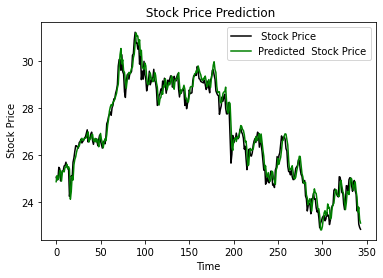

In [27]:
predicted  = model.predict(test_X)

real_price = y_scaler.inverse_transform(test_label[:,0])
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler.inverse_transform(predicted)
plt.plot(real_price, color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [28]:
len_t = len(test_label)
len_t

344

In [29]:
len(predicted)

344

In [51]:
testing_data = stock_orig.iloc[-len(predicted)-1:,:]

In [52]:
len(testing_data)

345

In [50]:
real_price[0]

array([25.05999947])

In [53]:
testing_data[:]

,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2020-10-06,24.620001,24.799999,24.620001,24.780001,41529205,-0.325962,-0.319469,46.940185,24.854,25.870669,23.837331,24.789999,25.23,25.23,24.349999
2020-10-07,24.780001,25.059999,24.700001,25.059999,51322696,-0.264574,-0.308490,52.185079,24.835,25.820890,23.849110,24.855000,25.23,25.23,24.480000
2020-10-08,25.040001,25.040001,24.799999,24.940001,74046496,-0.223036,-0.291399,49.908156,24.813,25.768429,23.857572,24.715000,25.23,24.95,24.480000
2020-10-09,25.100000,25.139999,24.840000,24.980000,30779128,-0.184759,-0.270071,50.680616,24.800,25.738765,23.861235,24.730000,25.23,24.94,24.520000
2020-10-12,25.020000,25.520000,24.980000,25.480000,47534936,-0.112778,-0.238613,59.158967,24.817,25.791414,23.842586,24.855000,25.23,24.94,24.770000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,23.900000,23.959999,23.480000,23.620001,245696511,0.044707,0.146766,39.318923,24.523,25.375223,23.670777,24.320000,23.99,24.32,24.320000
2022-02-23,23.700001,23.879999,23.639999,23.799999,105482891,-0.010405,0.115332,42.171200,24.460,25.330218,23.589782,24.305000,23.99,24.32,24.290000
2022-02-24,23.340000,23.500000,22.920000,23.059999,275542543,-0.112497,0.069766,34.906850,24.373,25.419845,23.326155,24.005000,23.99,24.04,23.970000


In [109]:
def rsi_signal(rsi):
  rsi_val = float(rsi)
  if rsi_val >= 70:
    return -1
  if rsi_val <= 30:
    return 1
  else:
    return 0

def predict_signal(current, predict, threshold=0.004):
  diff = (current - predict)/current
  # print(diff)
  if abs(diff) >= threshold:
    if np.sign(diff) > 0:
      return -1
    else:
      return 1
  else:
    return 0

def trade(price, capital, state, stock, rsi, macd, ml, bb, threshold=0.15, min_lot=500):
  remain = 0
  score = rsi*0.2+macd*0.2+bb*0.2+ml*0.4
  #print(score)
  if score > threshold and state != 1:
    lots = math.floor(capital / (price*min_lot))
    amount = price * lots * min_lot
    if lots > 1 and capital > amount:
      remain = capital - amount
    else:
      return None, None, None
    return remain, lots, 1
  elif score <= -0.2 and state != 0:
    values = capital + price * stock * min_lot
    return values, 0, 0
  else:
    return None, None, None

def macd_signal(macd, prev_macd, signal, prev_signal):
  if prev_signal > prev_macd and signal < macd:
    return 1
  elif prev_signal < prev_macd and signal > macd:
    return -1
  else:
    return 0

def bollinger_signal(prev_row, curr_row):
  if prev_row['Close'] < prev_row['bollinger_lbond'] and curr_row['Close'] > curr_row['bollinger_lbond']:
    return 1
  elif prev_row['Close'] > prev_row['bollinger_hband'] and curr_row['Close'] < curr_row['bollinger_hband']:
    return -1
  else:
    return 0

In [33]:
trade(25.4,200000, 0, 0, -1,0,0, 1)

(None, None, None)

In [112]:
money_sequence = []
count = 0
init_capital = 1000000
init_state = 0
init_stock = 0
cash_in_hand = init_capital
p_signal = 0
p_macd = 0
money_sequence.append(cash_in_hand)
for index, row in testing_data.iterrows():
  if count == 0:
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1
    prev_r = row
    continue
  if count < len(predicted)-1:
    rsi_sig = rsi_signal(row['rsi'])
    ml_sig = predict_signal(row['Close'], predicted[count][0])
    macd_sig = macd_signal(row['macd'], p_macd, row['macd_signal'], p_signal)
    bollinger_sig = bollinger_signal(prev_r, row)
    #print(rsi_sig, macd_sig, bollinger_sig, ml_sig, row['Close'], predicted[count][0])
    remain, lots, state = trade(row['Close'],cash_in_hand, init_state, init_stock, rsi_sig,macd_sig,ml_sig,bollinger_sig)
    if (remain != None):
      cash_in_hand = remain
      init_state = state
      init_stock = lots
      print("Trading at: ", index, " long " if init_state == 1 else " short ", row['Close'], cash_in_hand, init_stock)
    if state == 0:
      money_sequence.append(remain)
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1
  prev_r = row

if init_stock > 0:
  market_money = cash_in_hand+row['Close']*init_stock*500
  money_sequence.append(market_money)
money_sequence

Trading at:  2020-10-07 00:00:00  long  25.059999465942383 10130.021095275879 79
Trading at:  2020-10-12 00:00:00  short  25.479999542236328 1016590.0030136108 0
Trading at:  2020-11-19 00:00:00  long  26.520000457763672 8829.985618591309 76
Trading at:  2020-11-27 00:00:00  short  27.079999923706055 1037869.9827194214 0
Trading at:  2020-12-08 00:00:00  long  26.459999084472656 5930.018424987793 78
Trading at:  2021-01-12 00:00:00  short  28.399999618530273 1113530.0035476685 0
Trading at:  2021-01-20 00:00:00  long  30.079999923706055 570.0063705444336 74
Trading at:  2021-01-25 00:00:00  short  30.280000686645508 1120930.0317764282 0
Trading at:  2021-01-28 00:00:00  long  28.700000762939453 1630.0020217895508 78
Trading at:  2021-02-16 00:00:00  short  30.899999618530273 1206729.9871444702 0
Trading at:  2021-02-18 00:00:00  long  30.780000686645508 6309.96036529541 78
Trading at:  2021-03-16 00:00:00  short  29.260000228881836 1147449.969291687 0
Trading at:  2021-03-19 00:00:00  

[1000000,
 1016590.0030136108,
 1037869.9827194214,
 1113530.0035476685,
 1120930.0317764282,
 1206729.9871444702,
 1147449.969291687,
 1123269.9365615845,
 1146669.9514389038,
 1177479.9785614014,
 1080679.9755096436,
 1097689.9785995483,
 1109169.9285507202,
 1057929.9573898315,
 1111479.9671173096,
 1050059.9069595337,
 1055869.960784912,
 1037009.9983215332,
 1037009.9983215332,
 991960.0210189819,
 1038160.0370407104,
 996400.0768661499]

In [113]:
final_profit = money_sequence[-1]/init_capital - 1
print("final profit is ", final_profit*100,"%")

final profit is  -0.3599923133850047 %
